In [1]:
import sys
import numpy as np

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    else:
        return v / norm

# -- CONSTANT VARS ---
num_waypoints = 10
radius = 10
circle_center = [0, -10., -30.]

EPSILON = 2.
#2 * np.pi  * radius * 0.2
#2 * np.pi * radius / num_waypoints * 6 # how decide this??
LOOPS = 1


AMBITION = 5.5
# -- END CONSTANT VARS -- 

theta = np.linspace(0, 2*np.pi * LOOPS, num_waypoints)
start_pose = np.array([0, -15., -2., np.pi / 2])

target_pose = np.zeros(4)
target_pose[:3] = start_pose[:3] + np.array([9.0,-9.0,0.0])
target_pose[3] = start_pose[3] + np.pi/2

waypoint_coords = np.vstack((np.linspace(start_pose[0], target_pose[0], num=num_waypoints),
                             np.linspace(start_pose[1], target_pose[1], num=num_waypoints),
                             np.linspace(start_pose[2], target_pose[2], num=num_waypoints),
                             np.linspace(start_pose[3], target_pose[3], num=num_waypoints)))

In [2]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
%reload_ext autoreload
%autoreload 

from IPython.display import HTML, display
sys.path.insert(0, '../')
from flightgoggles.env import *

if __name__ == "__main__":
    # drone flips over when going too fast ? ? ? SimSpeed adjustment needed??
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_testing.yaml",
        cfg_uav="multicopterDynamicsSimSpeed.yaml") # 30 max_speed/accel multicopterDynamicsSimSpeed
    env.set_state_vehicle(vehicle_id="uav1", 
                          position = waypoint_coords.T[0][:3],
                          attitude_euler_angle=np.array([0., 0., 0.]))
    curr_pos = env.get_state("uav1")["position"]
    curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
    curr_vel = env.get_state("uav1")["velocity"]

    fol_accumulator = None
    pos_accumulator = np.array([curr_pos])
    per_accumulator = None
    
    rand_accumulator = None
    
    curr_waypoint = waypoint_coords.T[0]
    
    time_counter = 0
    crash = False
    for waypoint in waypoint_coords.T:
        prev_waypoint = curr_waypoint
        curr_waypoint = waypoint
                
        while np.linalg.norm(curr_pos - curr_waypoint[:3]) >= EPSILON:
            time_counter += 0.01
            curr_pos = env.get_state("uav1")["position"]
            curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
            curr_vel = env.get_state("uav1")["velocity"]
            
            # clean solution from: https://stackoverflow.com/questions/31273991/
            d = curr_waypoint[:3] - prev_waypoint[:3]
            t = -np.dot(prev_waypoint[:3] - curr_pos, d) / np.linalg.norm(d)**2
            # 2d only for now
            curr_pos_perpend = prev_waypoint[:3] + (d)*t
            
            if (np.array_equal(curr_waypoint, waypoint_coords.T[-1]) or 
                np.array_equal(curr_waypoint, waypoint_coords.T[1])):
                collided = env.proceed_waypoint(vehicle_id="uav1",
                                                waypoint_command=curr_waypoint,
                                                duration=0.01)
            else:
                target_pose = (curr_pos_perpend + 
                               normalize(curr_waypoint[:3] - curr_pos_perpend) * AMBITION)
            
                # curr_att considers x=0 as pi/2
                att_to_target = np.arctan2(target_pose[1] - curr_pos[1],
                                           target_pose[0] - curr_pos[0])
                vel_att = np.arctan2(curr_vel[1], curr_vel[0])
                    
                
                # MISC
                rand_accumulator = np.append(rand_accumulator, (att_to_target - vel_att))

                curr_att -= np.pi/2
                
                pos_error = np.array([target_pose[0] - curr_pos[0],
                                      target_pose[1] - curr_pos[1],
                                      target_pose[2] - curr_pos[2]])
                
                pid = np.array(7 * pos_error - 3 * curr_vel)
                pid[2] -= 9.81
                print(np.linalg.norm(pid))
                collided = env.proceed_angular_rate(vehicle_id="uav1",
                                                    angular_rate_command=(att_to_target - vel_att) ,
                                                    thrust_command=np.linalg.norm(pid),
                                                    duration=0.01)

            # [-1.16251645e-15 -1.32971352e+01  3.49065850e+00] <-- ANGULAR VEL
            # 41.08827204933301 < -- THRUST
    
    
            if per_accumulator is None:
                per_accumulator = np.array([curr_pos_perpend])
            else:
                per_accumulator = np.vstack((per_accumulator, curr_pos_perpend))
    
            pos_accumulator = np.vstack((pos_accumulator, curr_pos))
            if collided:
                crash = True
                break
        if crash:
            print("CRASHED! :(")
            break
    
#     f = open("observation notes target circular.txt", "a")
#     if not crash:
#         f.write(string + " it took {:.2f} sec\n".format(time_counter))
#     else:
#         f.write(string + " it crashed :(\n")
#     f.close()
    
    with np.printoptions(precision=2, suppress=True):
        print("Final pose", np.append(env.get_state("uav1")["position"],
                                      env.get_state("uav1")["attitude_euler_angle"][2]))
        
    ani_set = env.plot_state_video(flag_save=False, filename="uav", dpi=200)
    if "cam1" in ani_set.keys():
        display(HTML(ani_set["cam1"].to_html5_video()))
    env.close()











CRASHED! :(
Final pose [  0.29 -15.06 -20.12   0.38]


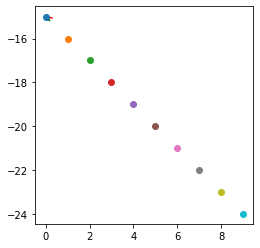

In [5]:
# Orange dots are the waypoints, dotted are waypoints
# coloration suggests the order
import itertools
import matplotlib.pyplot as plt

colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

plt.gca().set_aspect('equal', adjustable='box')
plt.plot(pos_accumulator.T[0], pos_accumulator.T[1], 'r')
plt.plot(per_accumulator.T[0], per_accumulator.T[1], 'g')
for column in waypoint_coords.T:
    plt.plot(column[0], column[1], 'o')

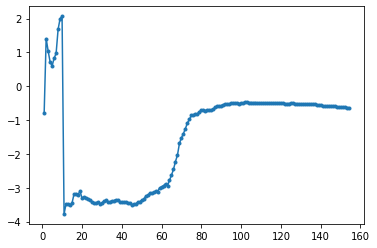

In [4]:
import matplotlib.pyplot as plt
x = np.arange(rand_accumulator.size)
y = rand_accumulator
#linear with a gap b/c pi to -pi
plt.plot(x, y, marker='.')